In [2]:
import torch 
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In this notebook, we'll be going a step further from the bigram approach:
* training an MLP on inputs with longer context lengths (3 or more characters for now)
* including an embedding layer to learn a better representation of the characters
* creating a hidden layer with a tanh activation
* output layer with a softmax to create probablity distribution 

In [3]:
words = open('names.txt').read().splitlines()

In [4]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [85]:
# set up the vocab size
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['.'] = 0 # special token
itos = {i:c for c,i in stoi.items()}

In [136]:
BLOCK_SIZE = 3 # context

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE
        for c in w + '.':
            idx = stoi[c]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # rm first char index
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_val, y_val = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

In [137]:
X_train.size()

torch.Size([182691, 3])

In [240]:
EMB_DIM = 10

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, EMB_DIM), generator=g)
W1 = torch.randn((EMB_DIM * BLOCK_SIZE, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) * 0.1
b2 = torch.randn(27, generator=g) * 0
params = [C, W1, b1, W2, b2]

In [241]:
sum(p.nelement() for p in params) # param count

11897

In [242]:
for p in params:
    p.requires_grad = True

In [243]:
stepi = []
lossi = []

In [244]:
idx = torch.randint(0, X_train.shape[0], (64,)) # creating mini batches over random indices
emb = C[X_train[idx]]
print(emb.shape)
print(emb.view(emb.size(0),-1).shape)

torch.Size([64, 3, 10])
torch.Size([64, 30])


In [245]:
for i in range(1):
    # forward pass
    idx = torch.randint(0, X_train.shape[0], (64,)) # creating mini batches over random indices
    emb = C[X_train[idx]].view(-1, EMB_DIM * BLOCK_SIZE)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2

    # l2 = 0.01 * (torch.sum(W1**2) + torch.sum(W2**2))
    loss = F.cross_entropy(logits, y_train[idx])

    # h1 = torch.tanh(emb @ W1 + b1)
    # h2 = torch.tanh(h1 @ W2 + b2)
    # logits = h2 @ W3 + b3
    # loss = F.cross_entropy(logits, y_train[idx])

    # zero grad
    for p in params:
        p.grad = None

    # backward
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0: 
        print(f"epoch {i} | loss: {loss:.4f}")

    # stepi.append(i)
    # lossi.append(loss.log10().item())

loss.item()

epoch 0 | loss: 4.1973


4.197343826293945

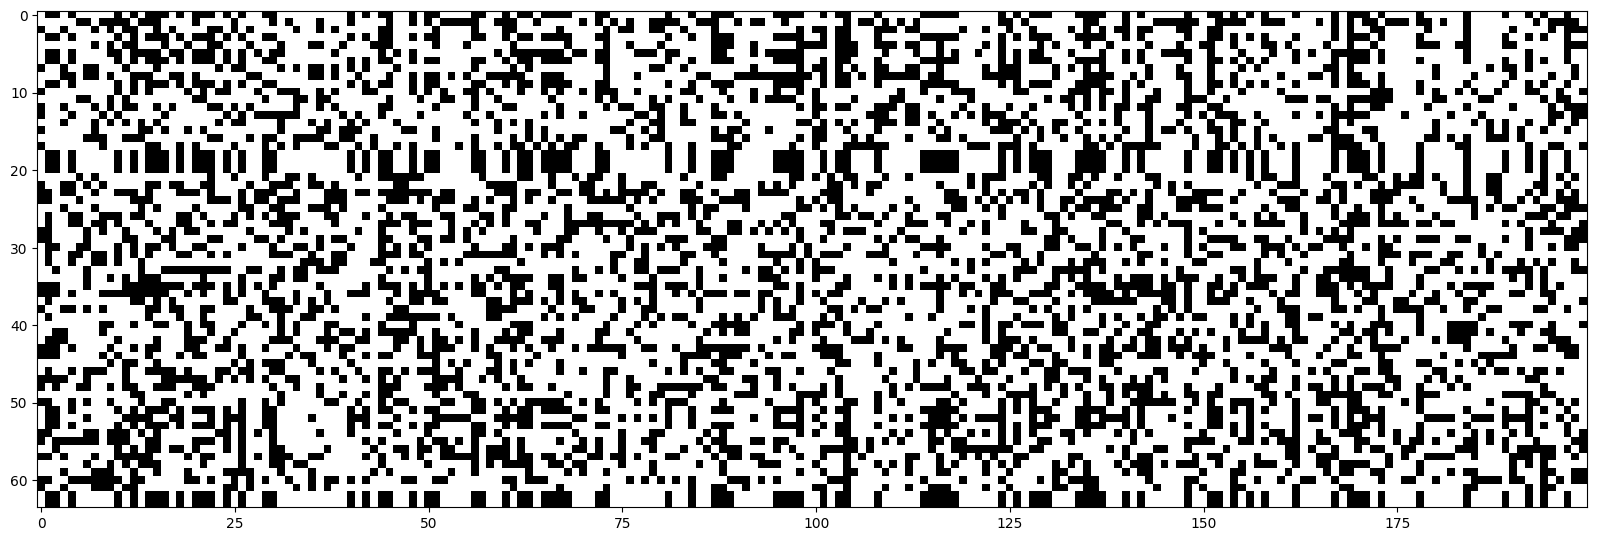

In [246]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

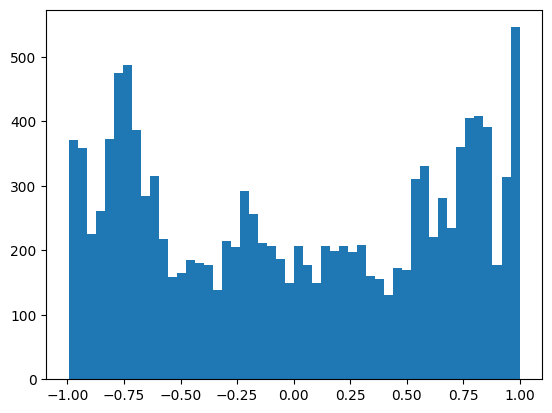

In [238]:
plt.hist(h.view(-1).tolist(), 50);

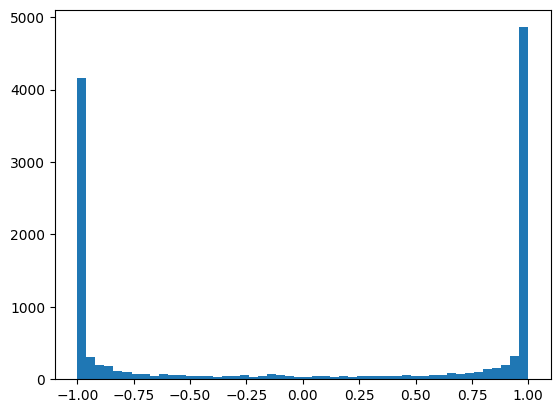

In [225]:
plt.hist(h.view(-1).tolist(), 50);

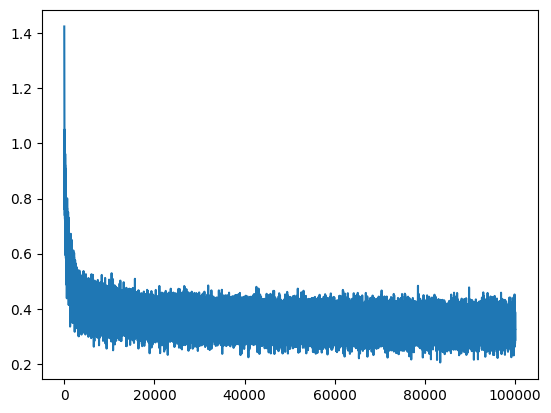

In [156]:
# batch64
plt.plot(stepi, lossi)

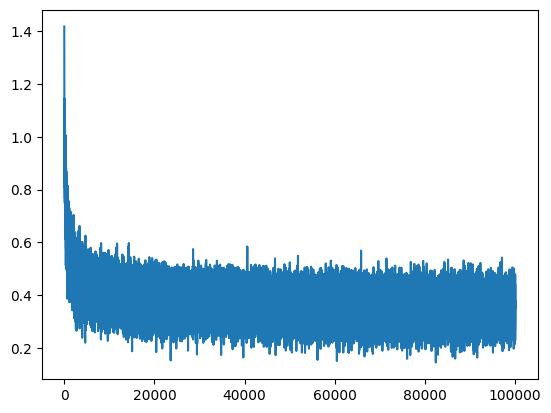

In [150]:
# batch32
plt.plot(stepi, lossi)

In [170]:
# training loss over the full training set
emb = C[X_train].view(-1, EMB_DIM * BLOCK_SIZE)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss.item()

2.0567357540130615

In [171]:
# val loss
emb = C[X_val].view(-1, EMB_DIM * BLOCK_SIZE)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
loss.item()

2.1300973892211914

In [172]:
# test loss
emb = C[X_test].view(-1, EMB_DIM * BLOCK_SIZE)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_test)
loss.item()

2.1434171199798584

In [106]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amirick.
hiimleigta.
caskan.
saeja.
hutnder.
sarti.
geri.
neronia.
chaiir.
kaleigh.
hamon.
cadesian.
shoil.
alian.
quinze.
paijarixi.
jaxen.
duran.
edde.


# Learning rate initialization technique

In [209]:
EMB_DIM = 10

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, EMB_DIM), generator=g)
W1 = torch.randn((EMB_DIM * BLOCK_SIZE, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g) * 0
params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

In [210]:
lre = torch.linspace(-3, 0, 1000) # tensor of size [1000] spread out from -3 to 0
lrs = 10**lre # learning rates spread out from 0.001 to 1

In [211]:
lri = []
lossi = []

for i in range(1000):
    # forward pass
    idx = torch.randint(0, X_train.shape[0], (64,)) # creating mini batches over random indices
    emb = C[X_train[idx]].view(-1, EMB_DIM * BLOCK_SIZE)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[idx])
    print(loss.item())

    # zero grad
    for p in params:
        p.grad = None

    # backward
    loss.backward()

    lr = lrs[i]
    # update
    for p in params:
        p.data += -lr * p.grad

    lri.append(lr)
    lossi.append(loss.item())

    # stepi.append(i)
    # lossi.append(loss.log10().item())

loss.item()

25.412076950073242
24.960102081298828
22.334226608276367
26.939409255981445
30.658588409423828
25.029556274414062
24.317527770996094
25.63251304626465
23.563217163085938
24.785871505737305
26.71943473815918
29.78579330444336
25.641244888305664
26.279422760009766
26.47990608215332
26.02263641357422
26.013179779052734
27.652616500854492
25.50037956237793
25.03707504272461
25.149675369262695
25.206119537353516
22.527353286743164
24.901792526245117
26.26892852783203
24.417070388793945
26.672155380249023
22.309532165527344
26.76412010192871
28.425386428833008
24.076807022094727
23.918909072875977
23.7745418548584
24.464183807373047
25.09384536743164
24.667644500732422
25.207714080810547
24.812259674072266
23.694332122802734
26.859052658081055
23.684200286865234
24.482751846313477
22.9853572845459
24.293968200683594
28.071264266967773
26.180349349975586
23.60114097595215
23.825298309326172
23.40693473815918
22.697710037231445
24.01326560974121
21.243688583374023
24.486515045166016
21.0772666

10.988043785095215

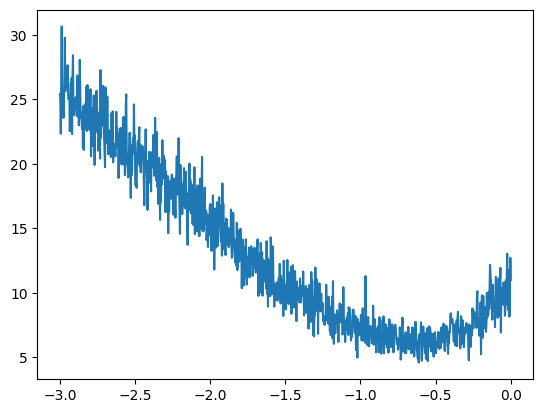

In [213]:
plt.plot(lre, lossi)